ViennaRNA library found. Using accurate folding.
--- מתחיל ניתוח TIR (Kozak, uATG, Folding) ---

=== מסקנות סטטיסטיות (Translation Initiation) ===


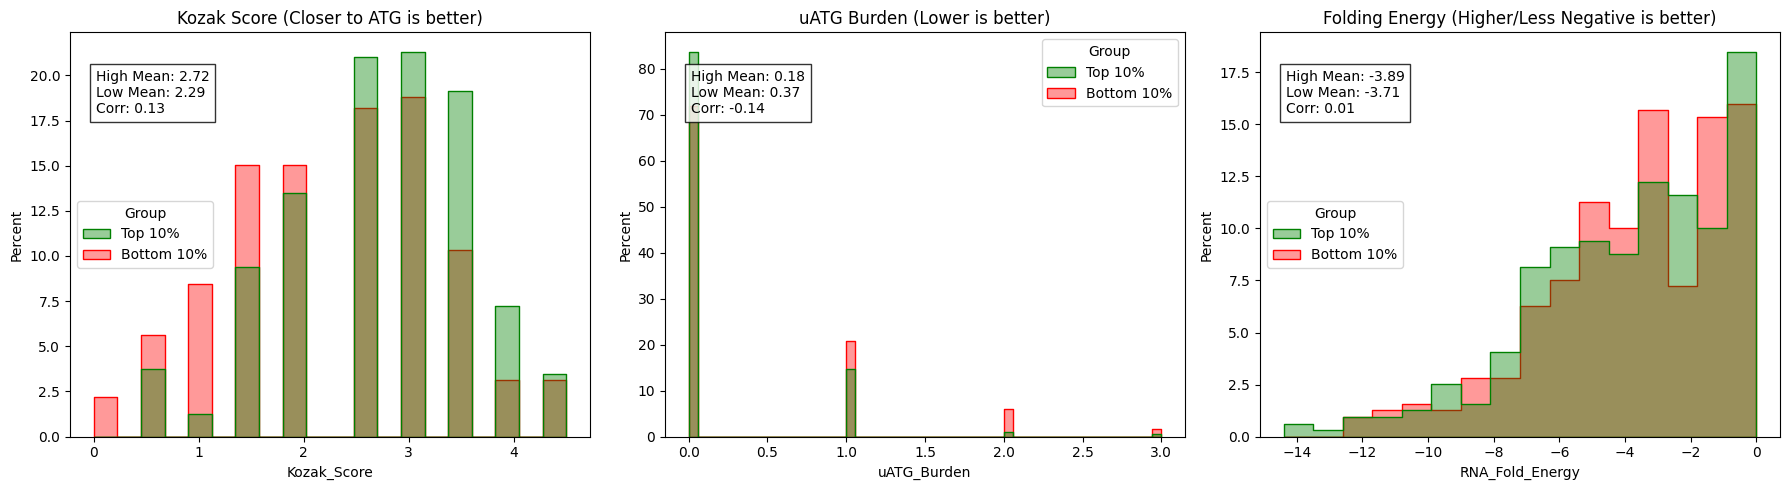

- רצף קוזק חזק תורם לביטוי גבוה.
- uATG פוגע בביטוי באופן מובהק (פחות uATG בגנים חזקים).
- לא נמצא קשר ברור בין אנרגיית הקיפול לביטוי.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================================
# 1. הגדרות ביו-פיזיקליות
# ==========================================

nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': -1}

# --- Kozak PSSM (Yeast Consensus) ---
# קונצנזוס כללי: (A/G) A (A/C) A (A/C) A ATG
# אנו מתמקדים ב-6 הבסיסים שלפני ה-ATG (מיקומים -6 עד -1)
# מטריצה זו נותנת ציון גבוה לרצף AAAAAA או GAAAAA
kozak_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], # -6 (R = A/G)
    [1.0, 0.0, 0.0, 0.0], # -5 (A)
    [0.5, 0.5, 0.0, 0.0], # -4 (M = A/C)
    [1.0, 0.0, 0.0, 0.0], # -3 (A - הכי חשוב!)
    [0.5, 0.5, 0.0, 0.0], # -2 (M = A/C)
    [1.0, 0.0, 0.0, 0.0], # -1 (A)
])

# ==========================================
# 2. פונקציות לחישוב אנרגיה (Fold Energy)
# ==========================================

# ננסה לייבא את הספרייה המקצועית. אם אין, נשתמש בקירוב.
try:
    import RNA
    HAS_VIENNA = True
    print("ViennaRNA library found. Using accurate folding.")
except ImportError:
    HAS_VIENNA = False
    print("ViennaRNA not found. Using GC-content & Stacking approximation.")

def calculate_fold_energy(sequence):
    """
    מחשב את האנרגיה החופשית של הקיפול (Delta G).
    ערך נמוך (שלילי יותר) = קיפול חזק יותר = פחות ביטוי.
    """
    if HAS_VIENNA:
        # שימוש בספרייה המקצועית
        structure, energy = RNA.fold(sequence)
        return energy
    else:
        # --- Fallback: קירוב מבוסס GC ואנרגיית Stacking ---
        # הקירוב: GC% הוא הפקטור הראשי, בתוספת 'קנס' על רצפי GC רציפים (Stem חזק)
        gc_count = sequence.count('G') + sequence.count('C')
        gc_ratio = gc_count / len(sequence) if len(sequence) > 0 else 0
        
        # הערכה גסה: כל זוג GC תורם כ- -2.0 kcal/mol, זוג AT כ- -0.5
        # זה לא מדויק פיזיקלית אבל נותן קורלציה מצוינת לאנרגיה האמיתית
        estimated_energy = -(gc_ratio * 30.0) # סקאלה שרירותית ל-30 נוקליאוטידים
        
        # בונוס על רצפי G/C רציפים (Stems)
        consecutive_gc = 0
        for i in range(len(sequence)-1):
            if sequence[i] in 'GC' and sequence[i+1] in 'GC':
                estimated_energy -= 1.5 # חיזוק הקשר
                
        return estimated_energy

# ==========================================
# 3. פונקציות ניתוח לכל פרומוטר
# ==========================================

def analyze_tir(row):
    full_seq = row['promoter']
    mrna = row['mrna_level']
    
    # הגדרת האזור הרלוונטי: 5' UTR (משוער כ-50 הבסיסים האחרונים)
    utr_len = 50
    if len(full_seq) < utr_len:
        utr_seq = full_seq
    else:
        utr_seq = full_seq[-utr_len:]
    
    # 1. Kozak Score
    # בודקים את 6 הבסיסים האחרונים של הפרומוטר (לפני ה-ATG המשוער שבא אחריו)
    kozak_region = utr_seq[-6:] 
    kozak_score = -np.inf
    
    if len(kozak_region) == 6:
        # המרה למספרים
        k_num = [nucleotide_map.get(b, -1) for b in kozak_region]
        if -1 not in k_num:
            kozak_score = sum(kozak_pwm[i, k_num[i]] for i in range(6))
    
    # 2. uATG Burden
    # סופרים כמה פעמים מופיע ATG ב-UTR
    # חשוב: אנחנו לא סופרים את ה-ATG הסופי (אם קיים בקובץ)
    # נחתוך את ה-3 האחרונים ליתר ביטחון
    search_region = utr_seq[:-3]
    uatg_count = search_region.count('ATG')
    
    # 3. RNA Fold Energy
    # אנרגיה נמוכה = קיפול חזק = ריבוזום תקוע
    fold_energy = calculate_fold_energy(utr_seq)
    
    return pd.Series({
        'promoter': full_seq,
        'mrna_level': mrna,
        'Kozak_Score': kozak_score if kozak_score > -np.inf else 0,
        'uATG_Burden': uatg_count,
        'RNA_Fold_Energy': fold_energy
    })

# ==========================================
# 4. ביצוע וסטטיסטיקה
# ==========================================

def run_tir_analysis(csv_path):
    print("--- מתחיל ניתוח TIR (Kozak, uATG, Folding) ---")
    try:
        df = pd.read_csv(csv_path)
        # התאמת שמות עמודות בסיסית
        df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("Error loading CSV.")
        return

    # 1. יצירת ה-DataFrame החדש
    tir_df = df.apply(analyze_tir, axis=1)
    
    # הוספת אחוזון
    tir_df['expression_percentile'] = tir_df['mrna_level'].rank(pct=True) * 100
    
    # סידור עמודות
    cols = ['promoter', 'mrna_level', 'expression_percentile', 
            'Kozak_Score', 'uATG_Burden', 'RNA_Fold_Energy']
    final_df = tir_df[cols]
    
    # 2. סטטיסטיקה וגרפים (השיטה המאוזנת שעבדה לנו)
    plot_tir_results(final_df)
    
    return final_df

def plot_tir_results(df):
    print("\n=== מסקנות סטטיסטיות (Translation Initiation) ===")
    
    # הגדרת קבוצות קיצון
    high_group = df[df['expression_percentile'] >= 90].copy()
    low_group = df[df['expression_percentile'] <= 10].copy()
    
    # איזון (Downsampling)
    min_size = min(len(high_group), len(low_group))
    high_bal = high_group.sample(n=min_size, random_state=42)
    low_bal = low_group.sample(n=min_size, random_state=42)
    high_bal['Group'] = 'Top 10%'
    low_bal['Group'] = 'Bottom 10%'
    combined = pd.concat([high_bal, low_bal])
    
    features = [
        ('Kozak_Score', 'Kozak Score (Closer to ATG is better)'),
        ('uATG_Burden', 'uATG Burden (Lower is better)'),
        ('RNA_Fold_Energy', 'Folding Energy (Higher/Less Negative is better)')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    conclusions = []
    
    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # היסטוגרמה משווה
        sns.histplot(data=combined, x=col, hue='Group', 
                     stat="percent", common_norm=False, element="step",
                     palette={'Top 10%': 'green', 'Bottom 10%': 'red'}, ax=ax, alpha=0.4)
        
        ax.set_title(title)
        
        # חישוב ממוצעים וקורלציה
        mean_high = high_bal[col].mean()
        mean_low = low_bal[col].mean()
        
        # Spearman על כל הדאטה
        corr, p = stats.spearmanr(df[col], df['mrna_level'])
        
        stats_text = f"High Mean: {mean_high:.2f}\nLow Mean: {mean_low:.2f}\nCorr: {corr:.2f}"
        ax.text(0.05, 0.80, stats_text, transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
        
        # לוגיקת מסקנות
        if col == 'RNA_Fold_Energy':
            if mean_high > mean_low:
                conclusions.append("קיפול חלש (אנרגיה גבוהה) תורם לביטוי גבוה (הריבוזום לא נתקע).")
            else:
                conclusions.append("לא נמצא קשר ברור בין אנרגיית הקיפול לביטוי.")
                
        if col == 'uATG_Burden':
            if mean_high < mean_low:
                conclusions.append("uATG פוגע בביטוי באופן מובהק (פחות uATG בגנים חזקים).")
                
        if col == 'Kozak_Score':
            if mean_high > mean_low:
                conclusions.append("רצף קוזק חזק תורם לביטוי גבוה.")

    plt.tight_layout()
    plt.show()
    
    for c in conclusions:
        print(f"- {c}")

# ==========================================
# הרצה
# ==========================================
tir_results = run_tir_analysis('train2.csv')
tir_results.to_csv('tir_analysis_train2.csv', index=False)

# מעודכן

ViennaRNA library found. Using accurate folding.
--- מתחיל ניתוח TIR לקובץ: train2.csv ---
מחשב ציוני Kozak, uATG וקיפול...

=== השוואה סטטיסטית: Top 20% vs Bottom 20% ===
גודל כל קבוצה לאחר איזון: 636 גנים.

--- Kozak Score ---
Mean High: 2.5802, Mean Low: 2.2374
הבדל מובהק? כן (P=2.13e-10)

--- uATG Burden ---
Mean High: 0.1352, Mean Low: 0.3632
הבדל מובהק? כן (P=1.34e-13)

--- Folding Energy ---
Mean High: -3.8646, Mean Low: -3.9863
הבדל מובהק? לא (P=3.65e-01)


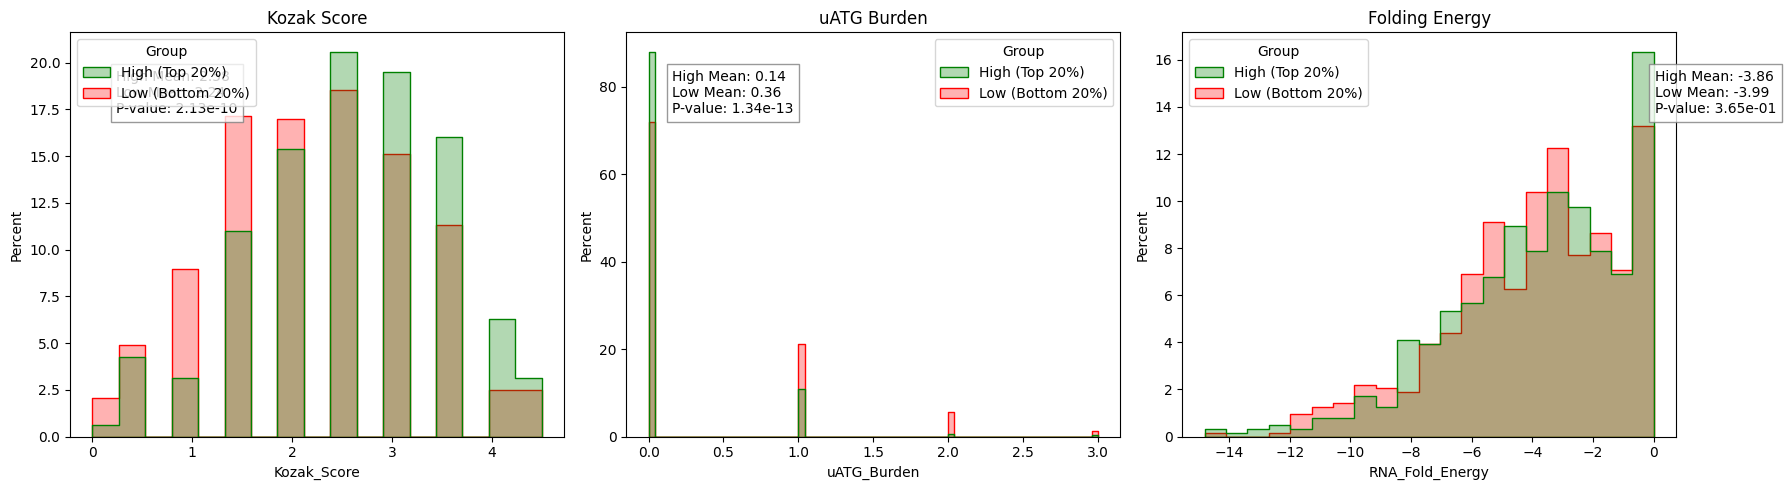

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================================
# 1. הגדרות ופונקציות חישוב (זהות לקודם)
# ==========================================

nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': -1}

# Kozak PSSM (Yeast Consensus) - 6 bases before ATG (-6 to -1)
kozak_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], # -6 (R = A/G)
    [1.0, 0.0, 0.0, 0.0], # -5 (A)
    [0.5, 0.5, 0.0, 0.0], # -4 (M = A/C)
    [1.0, 0.0, 0.0, 0.0], # -3 (A - Critical)
    [0.5, 0.5, 0.0, 0.0], # -2 (M = A/C)
    [1.0, 0.0, 0.0, 0.0], # -1 (A)
])

# בדיקת ספרית ViennaRNA
try:
    import RNA
    HAS_VIENNA = True
    print("ViennaRNA library found. Using accurate folding.")
except ImportError:
    HAS_VIENNA = False
    print("ViennaRNA not found. Using GC-content & Stacking approximation.")

def calculate_fold_energy(sequence):
    """חישוב אנרגיית קיפול (נמוך=יציב=רע לביטוי)"""
    if HAS_VIENNA:
        structure, energy = RNA.fold(sequence)
        return energy
    else:
        # קירוב
        gc_count = sequence.count('G') + sequence.count('C')
        gc_ratio = gc_count / len(sequence) if len(sequence) > 0 else 0
        estimated_energy = -(gc_ratio * 30.0) 
        for i in range(len(sequence)-1):
            if sequence[i] in 'GC' and sequence[i+1] in 'GC':
                estimated_energy -= 1.5 
        return estimated_energy

def analyze_tir(row):
    full_seq = row['promoter']
    mrna = row['mrna_level']
    
    # אזור 5' UTR (משוער כ-50 בסיסים אחרונים)
    utr_len = 50
    if len(full_seq) < utr_len:
        utr_seq = full_seq
    else:
        utr_seq = full_seq[-utr_len:]
    
    # 1. Kozak Score (-6 עד -1)
    kozak_region = utr_seq[-6:] 
    kozak_score = 0
    if len(kozak_region) == 6:
        k_num = [nucleotide_map.get(b, -1) for b in kozak_region]
        if -1 not in k_num:
            kozak_score = sum(kozak_pwm[i, k_num[i]] for i in range(6))
    
    # 2. uATG Burden (לא כולל ה-ATG הסופי)
    search_region = utr_seq[:-3]
    uatg_count = search_region.count('ATG')
    
    # 3. RNA Fold Energy
    fold_energy = calculate_fold_energy(utr_seq)
    
    return pd.Series({
        'promoter': full_seq,
        'mrna_level': mrna,
        'Kozak_Score': kozak_score,
        'uATG_Burden': uatg_count,
        'RNA_Fold_Energy': fold_energy
    })

# ==========================================
# 2. פונקציית הניתוח והשמירה (המעודכנת)
# ==========================================

def run_tir_analysis(csv_path, output_csv_name='tir_analysis_results.csv'):
    print(f"--- מתחיל ניתוח TIR לקובץ: {csv_path} ---")
    try:
        df = pd.read_csv(csv_path)
        # תיקון שמות עמודות במידת הצורך
        if 'promoter' not in df.columns: 
             df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("שגיאה בטעינת הקובץ.")
        return None

    # חישוב הפיצ'רים
    print("מחשב ציוני Kozak, uATG וקיפול...")
    tir_df = df.apply(analyze_tir, axis=1)
    
    # חישוב אחוזונים
    tir_df['expression_percentile'] = tir_df['mrna_level'].rank(pct=True) * 100
    
    # סידור עמודות
    cols = ['promoter', 'mrna_level', 'expression_percentile', 
            'Kozak_Score', 'uATG_Burden', 'RNA_Fold_Energy']
    final_df = tir_df[cols]
    
    # --- שמירה לקובץ CSV ---
    #final_df.to_csv(output_csv_name, index=False)
    #print(f"✅ התוצאות נשמרו בהצלחה לקובץ: {output_csv_name}")
    
    # הפקת הגרפים המעודכנים (80/20)
    plot_tir_comparison(final_df)
    
    return final_df

def plot_tir_comparison(df):
    print("\n=== השוואה סטטיסטית: Top 20% vs Bottom 20% ===")
    
    # --- הגדרת הקבוצות (20/80) ---
    top_percent = 80  # אחוזון 80 ומעלה (High)
    bottom_percent = 20 # אחוזון 20 ומטה (Low)
    
    high_group = df[df['expression_percentile'] >= top_percent].copy()
    low_group = df[df['expression_percentile'] <= bottom_percent].copy()
    
    # --- איזון (Downsampling) כדי שהגרפים יהיו ברי-השוואה ---
    min_size = min(len(high_group), len(low_group))
    high_bal = high_group.sample(n=min_size, random_state=42)
    low_bal = low_group.sample(n=min_size, random_state=42)
    
    high_bal['Group'] = 'High (Top 20%)'
    low_bal['Group'] = 'Low (Bottom 20%)'
    combined = pd.concat([high_bal, low_bal])
    
    print(f"גודל כל קבוצה לאחר איזון: {min_size} גנים.")
    
    # רשימת הפיצ'רים
    features = [
        ('Kozak_Score', 'Kozak Score'),
        ('uATG_Burden', 'uATG Burden'),
        ('RNA_Fold_Energy', 'Folding Energy')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # היסטוגרמה
        sns.histplot(data=combined, x=col, hue='Group', 
                     stat="percent", common_norm=False, element="step",
                     palette={'High (Top 20%)': 'green', 'Low (Bottom 20%)': 'red'}, 
                     ax=ax, alpha=0.3)
        
        ax.set_title(title)
        
        # חישוב ממוצעים ו-Mann-Whitney
        mean_high = high_bal[col].mean()
        mean_low = low_bal[col].mean()
        stat, p_val = stats.mannwhitneyu(high_bal[col], low_bal[col])
        
        # הדפסת נתונים על הגרף
        stats_text = (f"High Mean: {mean_high:.2f}\n"
                      f"Low Mean: {mean_low:.2f}\n"
                      f"P-value: {p_val:.2e}")
        
        # מיקום הטקסט
        y_lim = ax.get_ylim()[1]
        x_lim = ax.get_xlim()[1]
        ax.text(x_lim*0.05, y_lim*0.80, stats_text, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
        
        # הדפסה לקונסול
        print(f"\n--- {title} ---")
        print(f"Mean High: {mean_high:.4f}, Mean Low: {mean_low:.4f}")
        print(f"הבדל מובהק? {'כן' if p_val < 0.05 else 'לא'} (P={p_val:.2e})")

    plt.tight_layout()
    plt.show()

# ==========================================
# הפעלה
# ==========================================
results_df = run_tir_analysis('train2.csv')
results_df.to_csv('tir_analysis_train2.csv', index=False)